# CHAPTER 0 - INTRODUCTION

# Python Project - Samuele Ceol 
A case study on the correlation between the labour market and suicide rates in Europe

## Flag codes

E = Estimated values

P = Provisional data

B = Break in series

In [519]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns

In [520]:
euro_countries = ['Ukraine','France','Spain','Sweden','Norway','Germany','Finland','Poland','Italy','United Kingdom','Romania','Belarus','Greece','Bulgaria','Iceland','Hungary','Portugal','Austria','Czechia','Serbia','Ireland','Lithuania','Latvia','Croatia','Bosnia and Herzegovina','Slovakia','Estonia','Denmark','Switzerland','Netherlands','Moldova','Belgium','Armenia','Albania','North Macedonia','Turkey','Slovenia','Montenegro','Kosovo','Azerbaijan','Cyprus','Luxembourg','Georgia','Andorra','Malta','Liechtenstein','San Marino','Monaco','Vatican City']

def OECD_prepare_data(data, value, drop_sex=True):
    # Drop unused columns
    drop_columns = ['INDICATOR', 'MEASURE', 'FREQUENCY', 'Flag Codes']

    if(drop_sex == True):
        drop_columns = np.append(drop_columns, 'SUBJECT')

    data = data.drop(drop_columns, axis=1)

    # Rename columns
    if(drop_sex == True):
        data.columns = ['country', 'year', value]
    else:
        data.columns = ['country', 'sex', 'year', value]

    # Modify sex column content
    if(drop_sex == False):
        data['sex'] = data['sex'].replace('TOT', 'total').replace('MEN', 'male').replace('WOMEN', 'female')

    return data

# CHAPTER 1 - DATA CURATION

# OECD Suicide Data - Description

For the OECD we have three distinct files, one for males, one for females and one aggregate (M/F).

The dataset contains only data related to european countries.

No age group distinction is provided.

The column LOCATION identifies the interested country with a unique three letter abbreviation.

Suicide rates are indicated as nr of suicides per 100.000 people.

In [521]:
suicide_tot = pd.read_csv('./source/suicide/OECD_suicides_total.csv')
suicide_male = pd.read_csv('./source/suicide/OECD_suicides_male.csv')
suicide_female = pd.read_csv('./source/suicide/OECD_suicides_female.csv')

In [522]:
suicide_tot.shape

(1955, 8)

In [523]:
suicide_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LOCATION    1955 non-null   object 
 1   INDICATOR   1955 non-null   object 
 2   SUBJECT     1955 non-null   object 
 3   MEASURE     1955 non-null   object 
 4   FREQUENCY   1955 non-null   object 
 5   TIME        1955 non-null   int64  
 6   Value       1955 non-null   float64
 7   Flag Codes  98 non-null     object 
dtypes: float64(1), int64(1), object(6)
memory usage: 122.3+ KB


In [524]:
suicide_tot.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,SUICIDE,TOT,100000PER,A,1960,13.1,NaN
1,AUS,SUICIDE,TOT,100000PER,A,1961,14.5,NaN
2,AUS,SUICIDE,TOT,100000PER,A,1962,16.9,NaN
3,AUS,SUICIDE,TOT,100000PER,A,1963,19.2,NaN
4,AUS,SUICIDE,TOT,100000PER,A,1964,17.8,NaN


# OECD Suicide Data - Required actions

We would like to join this three different entities into a single dataframe.


In [525]:
OECD_suicide = pd.concat([suicide_tot, suicide_male, suicide_female])

We can then standardize the content of the SUBJECT column

We can discard the INDICATOR, SUBJECT, MEASURE and FREQUENCY columns since they are only descriptive and not needed for our analysis

We can rename the columns

In [526]:
OECD_suicide = OECD_prepare_data(OECD_suicide, 'suicides_no', False)

To join the OECD dataset with the one provided by the World Health Organization, we want to change the three letters identifiers to the full country names.
To do that, we use the pycountry library.

In [527]:
import pycountry

OECD_suicide['country'] = OECD_suicide['country'].apply(
    lambda x: pycountry.countries.get(alpha_3=x).name 
    if len(x) == 3 
    else pycountry.countries.get(alpha_2=x).name
)

We can now filter out the countries in the dataset that are not in (geographical) Europe

TODO - find out if there is a better way to get the list of european countries

In [528]:
print('Initial nr of countries: ')
print(OECD_suicide['country'].nunique())

OECD_suicide = OECD_suicide[OECD_suicide['country'].isin(euro_countries)]

print('Final nr of countries: ')
print(OECD_suicide['country'].nunique())

#List of european countries that are not present in this dataset
print('European countries not present in this dataset: ')
print([x for x in euro_countries if x not in OECD_suicide['country'].unique().tolist()])

Initial nr of countries: 
41
Final nr of countries: 
27
European countries not present in this dataset: 
['Ukraine', 'Romania', 'Belarus', 'Bulgaria', 'Serbia', 'Croatia', 'Bosnia and Herzegovina', 'Moldova', 'Armenia', 'Albania', 'North Macedonia', 'Montenegro', 'Kosovo', 'Azerbaijan', 'Cyprus', 'Georgia', 'Andorra', 'Malta', 'Liechtenstein', 'San Marino', 'Monaco', 'Vatican City']


We can finally rename the remaining columns and see how the dataframe looks like.

TODO - Maintain the groupby even though we don't have duplicates

In [530]:
OECD_suicide = OECD_suicide.sort_values(['country', 'year','sex']).reset_index(drop = True)

In [531]:
OECD_suicide.head()

,country,sex,year,suicides_no
0,Austria,female,1960,14.7
1,Austria,male,1960,36.6
2,Austria,total,1960,24.2
3,Austria,female,1961,13.7
4,Austria,male,1961,35.5


In [573]:
print('Number of countries in OECD dataset: ' + str(OECD_suicide['country'].nunique()))

Number of countries in OECD dataset: 27


# WHO Suicide Data - Description

For the data provided by the World Health Organization we have a single file containing data for males and females with a further division by age group.

Suicide values are stored as totals unlike the previous dataframe where they were stored in relation to nr of suicides per 100.000.

The dataframe also contains information related to the total population of the country in the given year.


In [533]:
WHO_suicide = pd.read_csv('./source/suicide/WHO_suicides_aggregate.csv')

In [534]:
WHO_suicide.shape

(43776, 6)

In [535]:
WHO_suicide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43776 entries, 0 to 43775
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      43776 non-null  object 
 1   year         43776 non-null  int64  
 2   sex          43776 non-null  object 
 3   age          43776 non-null  object 
 4   suicides_no  41520 non-null  float64
 5   population   38316 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.0+ MB


In [536]:
WHO_suicide.head()

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,277900.0
1,Albania,1985,female,25-34 years,NaN,246800.0
2,Albania,1985,female,35-54 years,NaN,267500.0
3,Albania,1985,female,5-14 years,NaN,298300.0
4,Albania,1985,female,55-74 years,NaN,138700.0


# WHO Suicide Data - Required actions

Just like for the OECD data, we filter out the countries that are not in Europe.

In [537]:
print('Initial nr of countries: ')
print(WHO_suicide['country'].nunique())

WHO_suicide = WHO_suicide[WHO_suicide['country'].isin(euro_countries)]

print('Final nr of countries: ')
print(WHO_suicide['country'].nunique())

#List of european countries that are not present in this dataset
print('European countries not present in this dataset: ')
print([x for x in euro_countries if x not in WHO_suicide['country'].unique().tolist()])

Initial nr of countries: 
141
Final nr of countries: 
42
European countries not present in this dataset: 
['Czechia', 'Moldova', 'North Macedonia', 'Kosovo', 'Andorra', 'Liechtenstein', 'Vatican City']


We can also drop the rows in which suicide data is not present.

In [538]:
WHO_suicide = WHO_suicide[WHO_suicide['suicides_no'].notna()]

For our analysis, we are not considering the differences between age groups.

Because of this reason, we can drop the 'age' column and sum population and suicide numbers.


In [539]:
WHO_suicide = WHO_suicide.drop('age', axis=1).groupby(['country', 'year', 'sex']).sum().unstack()

Since the dataframe only has a division between males and females, we want to add a new category for the total values which contains the sum for both nr of suicides between males and females and value of the total population.

To facilitate this process, we compute the totals for suicides numbers and population in two different variables and then merge them.

We then flatten the hierarchical index


In [540]:
WHO_suicide_mf      = WHO_suicide['suicides_no'].assign(total=WHO_suicide['suicides_no'].sum(1)).stack(level='sex')
WHO_population_mf   = WHO_suicide['population'].assign(total=WHO_suicide['population'].sum(1)).stack(level='sex')

WHO_suicide = pd.DataFrame(
    pd.concat(
        [WHO_suicide_mf, WHO_population_mf], 
        axis=1
    ).to_records()).rename(columns = {'0':'suicides_no', '1':'population'}
) 

Before converting the suicide nr to suicide rates, we should first address the few rows with missing population data.

My initial idea was to use The World Bank census data in order to fill in the gaps in the poulation numbers for the WHO dataset

The following (now commented) code, was used to drop the columns were not needed, pivot longer the year columns and filter out the non european countries.

In [541]:
'''
census_tot      = pd.read_csv('./source/census_total.csv').drop(['Country Code', 'Indicator Code'], axis=1)
census_male     = pd.read_csv('./source/census_male.csv').drop(['Country Code', 'Indicator Code'], axis=1)
census_female   = pd.read_csv('./source/census_female.csv').drop(['Country Code', 'Indicator Code'], axis=1)

census = pd.concat([census_tot, census_male, census_female])

census = pd.melt(
    census, 
    id_vars = ['Country Name', 'Indicator Name'], 
    value_vars = [str(i).zfill(4) for i in range(1960,2020)], 
    var_name='year', 
    value_name='population'
).sort_values(
    ['Country Name', 'year', 'Indicator Name']
)

census = census[census['Country Name'].isin(euro_countries)]
census
'''

"\ncensus_tot      = pd.read_csv('./source/census_total.csv').drop(['Country Code', 'Indicator Code'], axis=1)\ncensus_male     = pd.read_csv('./source/census_male.csv').drop(['Country Code', 'Indicator Code'], axis=1)\ncensus_female   = pd.read_csv('./source/census_female.csv').drop(['Country Code', 'Indicator Code'], axis=1)\n\ncensus = pd.concat([census_tot, census_male, census_female])\n\ncensus = pd.melt(\n    census, \n    id_vars = ['Country Name', 'Indicator Name'], \n    value_vars = [str(i).zfill(4) for i in range(1960,2020)], \n    var_name='year', \n    value_name='population'\n).sort_values(\n    ['Country Name', 'year', 'Indicator Name']\n)\n\ncensus = census[census['Country Name'].isin(euro_countries)]\ncensus\n"

This solution was not implemented because I later realized that:

    - Only 9 rows, out of the total 3759, were missing this data
    - The two interested countries (Monaco and San Marino) were missing this data also in the other datasets

Given the small amount of interested rows, we can drop them without compromising the value of our data.

In [542]:
WHO_suicide = WHO_suicide[WHO_suicide['population'] != 0]

We can now convert the suicide values to suicides per 100.000 and then drop the population column.

Suicide rate = (Nr of suicides / population) * 100.000

In [543]:
WHO_suicide['suicides_no'] = ((WHO_suicide['suicides_no'] / WHO_suicide['population']) * 100000).round(1)
WHO_suicide = WHO_suicide.drop('population', axis=1)

In [544]:
WHO_suicide.head()

,country,year,sex,suicides_no
0,Albania,1987,female,1.9
1,Albania,1987,male,3.4
2,Albania,1987,total,2.7
3,Albania,1988,female,1.6
4,Albania,1988,male,2.9


# Suicide data - Merging the two datasets

We are now ready to combine the data coming from the two datasets

In case we have rows with the same country, year and sex, we compute the mean value for the suicide numbers among the two datasets

In [545]:
suicide = pd.concat([OECD_suicide, WHO_suicide]).groupby(['country', 'year', 'sex']).mean().reset_index().sort_values(['country', 'year','sex']).reset_index(drop=True)

print('Shape of OECD data: ' + str(OECD_suicide.shape))
print('Shape of WHO data: ' + str(WHO_suicide.shape))
print('Shape of final suicide dataset: ' + str(suicide.shape))

print('Nr of countries in WHO dataset: ' + str(WHO_suicide['country'].nunique()))
print('Nr of countries in OECD dataset: ' + str(OECD_suicide['country'].nunique()))
print('Nr of countries in final dataset: ' + str(suicide['country'].nunique()))

Shape of OECD data: (3903, 4)
Shape of WHO data: (3549, 4)
Shape of final suicide dataset: (4986, 4)
Nr of countries in WHO dataset: 41
Nr of countries in OECD dataset: 27
Nr of countries in final dataset: 42


In [546]:
suicide

,country,year,sex,suicides_no
0,Albania,1987,female,1.90
1,Albania,1987,male,3.40
2,Albania,1987,total,2.70
3,Albania,1988,female,1.60
4,Albania,1988,male,2.90
...,...,...,...,...
4981,United Kingdom,2015,male,12.00
4982,United Kingdom,2015,total,7.75
4983,United Kingdom,2016,female,3.30
4984,United Kingdom,2016,male,11.40


# Suicide data - Contextualizing Outliers

Identifying outliers using the z score.

We don't necessarily want to remove them, but we should be able to at least identify and contextualize them. 

This will also be useful to see how strongly (if at all) their presence influences our features correlation (Chapter 3).

"The Z-score is the signed number of standard deviations by which the value of an observation or data point is above (or below) the mean value of what is being observed or measured."

z-score bigger than +3: zscore    92
dtype: int64
z-score smaller than -3: zscore    0
dtype: int64
Number of male outliers: sex    92
dtype: int64
Number of female outliers: sex    0
dtype: int64
Outlier countries: ['Belarus' 'Estonia' 'Hungary' 'Latvia' 'Lithuania' 'Slovenia' 'Ukraine']


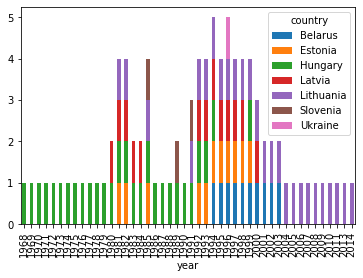

In [547]:
from scipy import stats

#We want to identify rows with a z-score <-3 or >3 (i.e. values that are at least 3 standard deviations from the mean)
suicide_no_outliers = suicide.copy()
suicide_no_outliers['zscore'] = (suicide.suicides_no - suicide.suicides_no.mean()) / suicide.suicides_no.std()

print('z-score bigger than +3: ' + str(suicide_no_outliers[['zscore']][suicide_no_outliers['zscore'] > 3].count()))
print('z-score smaller than -3: ' + str(suicide_no_outliers[['zscore']][suicide_no_outliers['zscore'] < -3].count()))

print('Number of male outliers: ' + str(suicide_outliers[['sex']][suicide_outliers['sex'] == 'male'].count()))
print('Number of female outliers: ' + str(suicide_outliers[['sex']][suicide_outliers['sex'] == 'female'].count()))

#Since there are no zscores smaller than -3, we can just work on the one bigger than 3
suicide_outliers = suicide_no_outliers[suicide_no_outliers.zscore>3]
suicide_no_outliers = suicide_no_outliers[suicide_no_outliers.zscore<3]

print('Outlier countries: ' + str(suicide_outliers['country'].unique()))

suicide_outliers[['year', 'country']].pivot_table(index='country', columns='year', aggfunc=len, fill_value=0).reset_index().set_index('country').T.plot(kind='bar', stacked=True)

del suicide_outliers['zscore']
del suicide_no_outliers['zscore']

We can notice how all the interested countries are ex eastern bloc nations. Historical and geographical closeness to the Russian Federation can lead us to believe that all this countries may share common factors leading to such high suicide rates.

The economic instability brought by the fall of the Soviet Union (1991) is undoubtedly the cause of most outliers being concetrated in the 90s. 

The high concentration that we see briefly at the beginning of the 80s is mostly correlated with the baltic states (Estonia/Latvia/Lithuania) and is probably caused by the social unrest that would lead to the Restoration of independence at the end of the same decade.

Another well documented factor related to this trend is the heavy alcohol consuption among the population of these countries (see: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1642767/)

<AxesSubplot:xlabel='year', ylabel='suicides_no'>

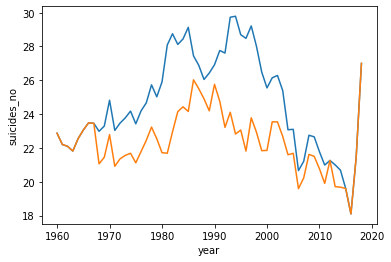

In [548]:
#Plotting the difference in the mean values between the two datasets
sns.lineplot(
    x='year',
    y='suicides_no',
    data=suicide[suicide['sex'] == 'male'].groupby(['year', 'sex']).suicides_no.mean().reset_index()
)

sns.lineplot(
    x='year',
    y='suicides_no',
    data=suicide_no_outliers[suicide_no_outliers['sex'] == 'male'].groupby(['year', 'sex']).suicides_no.mean().reset_index()
)

As expected, the line plotted by the dataset with the outliers removed has a noticeably smaller mean values. 

# Extra - Brief look at alcohol consuption and suicide rates in ex eastern bloc countries

In [612]:
alcohol_consumption = OECD_prepare_data(pd.read_csv('./source/extra/OECD_alcohol_consumption.csv'), 'alcohol_consumption')

alcohol_consumption['country'] = alcohol_consumption['country'].apply(
    lambda x: pycountry.countries.get(alpha_3=x).name 
    if x.isalpha() and len(x) == 3
    else (pycountry.countries.get(alpha_2=x).name if len(x) == 2 and x.isalpha() else x)
)

#alcohol_consumption_ebloc = alcohol_consumption.copy()
#alcohol_consumption_ebloc = alcohol_consumption_ebloc[alcohol_consumption_ebloc['country'].isin(suicide_outliers['country'].unique())]

#alcohol_consumption_europe = alcohol_consumption.copy()
#alcohol_consumption_europe = alcohol_consumption_europe[alcohol_consumption_europe['country'].isin(np.array(set(euro_countries) - set(suicide_outliers['country'].unique())))


#alcohol_grouped = alcohol_consumption.groupby('year').mean().reset_index()

# OECD Labour Market Data - Description

Unemployment rates (m/f)

Labour compensation (Average salary in us dollars - 1990-2019)

Hours worked - (tot - 1950-2019)

Tax wedge (tot - 2000-2019)

GPD per capita (total - US dollar per capita - 1960-2019)

Adult education level (Below upper secondary 1981-2019)

Wage level (% of workers earning less than two-thirds of median earnings,)

In [550]:
unemployment_rates = OECD_prepare_data(pd.read_csv('./source/labour/OECD_unemployment.csv'), 'unemployment_rates', False)
compensation = OECD_prepare_data(pd.read_csv('./source/labour/OECD_compensation.csv'), 'compensation')
hours = OECD_prepare_data(pd.read_csv('./source/labour/OECD_hours.csv'), 'hours_worked')
tax_wedge = OECD_prepare_data(pd.read_csv('./source/labour/OECD_taxWedge.csv'), 'tax_wedge')
gdp_per_capita = OECD_prepare_data(pd.read_csv('./source/labour/OECD_gdpPerCapita.csv'), 'GDP_per_capita')
adult_education = OECD_prepare_data(pd.read_csv('./source/labour/OECD_adult_education.csv'), 'adult_education')
wage_level = OECD_prepare_data(pd.read_csv('./source/labour/OECD_wage_level.csv'), 'wage_level')

# OECD Labour Market Data - Required actions

Left join so we don't lose any year (ie the first year will be the smallest one across all files). Of course we have plenty of NaN by joining in this way

In [551]:
join_columns = ['country', 'year']

labour = unemployment_rates.merge(
    compensation,
    on = join_columns,
    how = 'left'
).merge(
    hours,
    on = join_columns,
    how = 'left'
).merge(
    tax_wedge,
    on = join_columns,
    how = 'left'
).merge(
    gdp_per_capita,
    on = join_columns,
    how = 'left'
).merge(
    adult_education,
    on = join_columns,
    how = 'left'
).merge(
    wage_level,
    on = join_columns,
    how = 'left'
)

labour.shape

(3578, 10)

In [552]:
labour['country'] = labour['country'].apply(
    lambda x: pycountry.countries.get(alpha_3=x).name 
    if x.isalpha() and len(x) == 3
    else (pycountry.countries.get(alpha_2=x).name if len(x) == 2 and x.isalpha() else x)
)

In [553]:
labour = labour[labour['country'].isin(euro_countries)]
labour

,country,sex,year,unemployment_rates,compensation,hours_worked,tax_wedge,GDP_per_capita,adult_education,wage_level
0,Estonia,female,2000,13.292040,12734.665030,1884.0,41.309371,9408.179591,14.751366,NaN
1,Estonia,female,2001,12.186390,13185.754121,1877.0,40.963905,10292.284396,13.769239,NaN
2,Estonia,female,2002,10.042340,13971.491571,1879.0,42.088547,11635.368438,13.215323,24.935374
3,Estonia,female,2003,9.878282,15331.173161,1884.0,42.322317,13080.286690,12.355169,NaN
4,Estonia,female,2004,9.132123,16548.877597,1892.0,41.468851,14481.498229,11.743241,NaN
...,...,...,...,...,...,...,...,...,...,...
3540,Lithuania,total,2015,9.133333,23593.356366,1643.0,41.205057,28842.242746,8.644216,NaN
3541,Lithuania,total,2016,7.900000,24853.855693,1664.0,41.289383,30922.107210,7.484357,NaN
3542,Lithuania,total,2017,7.116667,26258.425699,1627.0,41.074653,33826.751533,7.171962,NaN
3543,Lithuania,total,2018,6.183333,27368.006669,1634.0,40.661721,36011.317619,7.022464,NaN


<AxesSubplot:xlabel='year'>

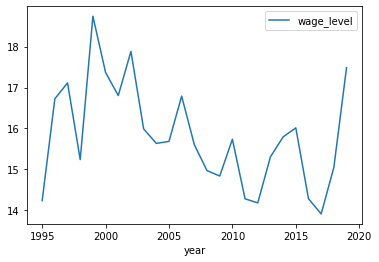

In [554]:
labour.groupby('year').mean().reset_index().plot(x='year', y='wage_level')

# CHAPTER 2 - DATA VISUALIZATION

# Suicide data - Visualization

<AxesSubplot:xlabel='year', ylabel='suicides_no'>

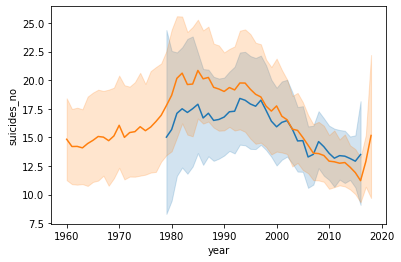

In [555]:
 sns.lineplot(
    x='year',
    y='suicides_no',
    data=WHO_suicide[WHO_suicide['sex'] == 'total'])

sns.lineplot(
    x='year',
    y='suicides_no',
    data=OECD_suicide[OECD_suicide['sex'] == 'total']) 

<AxesSubplot:xlabel='year', ylabel='suicides_no'>

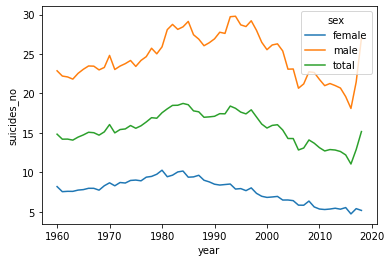

In [556]:
 sns.lineplot(
    x='year',
    y='suicides_no',
    hue='sex',
    data=suicide.groupby(['year', 'sex']).suicides_no.mean().reset_index()
)

In both of the previous plots we can notice a spike during the last years of the x axis. This is probably due to a low number of countries providing data for the most recent years. This means that potentially a low number of countries with high suicide rates can strongly influence the mean values during those years.

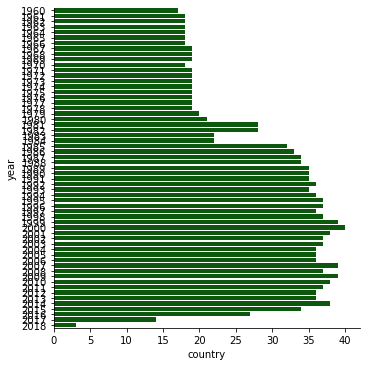

In [557]:
sns.catplot(
    y="year", 
    x="country", 
    data=suicide.groupby(['year', 'sex']).country.count().reset_index(), 
    kind='bar',
    orient='h',
    color='darkgreen'
)

As expected, we have a large pool of countries in the years going from 1979 to 2016 (which are the years covered by both datasets).
Fortunately, in this project we are more interested in analyzing the correlation of suicides to labour market features rather than doing an accurate representation of the suicide rates troughout the years. In any case we can keep this in mind in order to have more accurate representation during the course of this chapter.

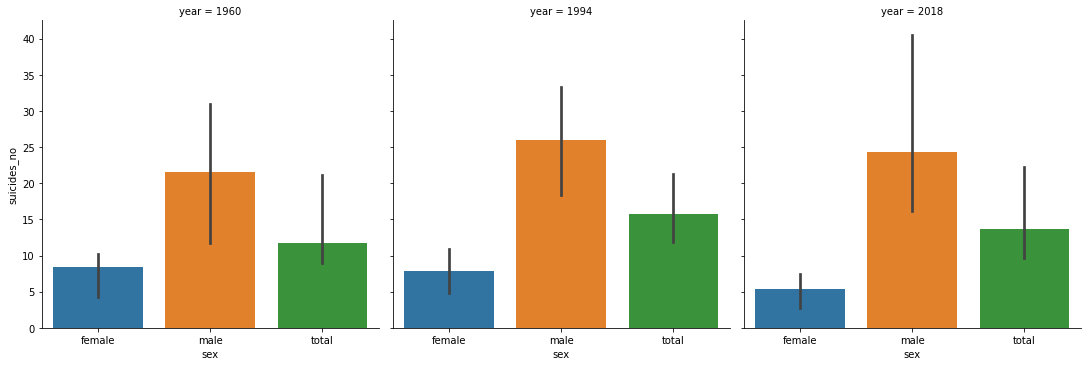

In [558]:
sns.catplot(
    x="sex", 
    y="suicides_no", 
    data=suicide[
        (suicide['year'] == suicide['year'].min()) | 
        (suicide['year'] == suicide['year'].median()) |
        (suicide['year'] == suicide['year'].max())
        ], 
    col='year', 
    estimator=np.median,
    kind='bar'
)

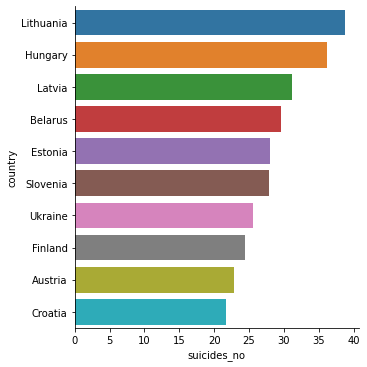

In [559]:
sns.catplot(
    y="country", 
    x="suicides_no", 
    data=suicide.groupby(['country']).suicides_no.mean().nlargest(10).reset_index(),
    kind='bar', 
    orient='h'
)

<Figure size 432x288 with 0 Axes>

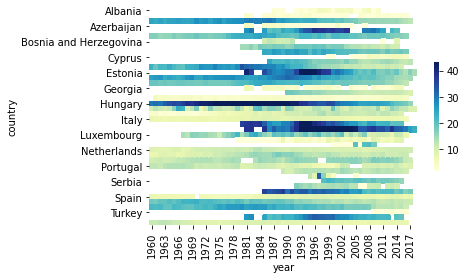

<Figure size 432x288 with 0 Axes>

In [560]:
df_heatmap = suicide[['country', 'year', 'suicides_no']].pivot_table(values='suicides_no',index='country',columns='year')

sns.heatmap(df_heatmap, cmap="YlGnBu",robust=True,cbar_kws={"shrink": 0.5})
plt.xticks(rotation=90) 
plt.figure()

# Labour market data - Visualization

# CHAPTER 3 - FEATURE CORRELATION

# Finding correlations in the processed data

In [561]:
merged_data = suicide.merge(
    labour,
    on = ['country', 'sex', 'year'],
    how = 'left'
)

<AxesSubplot:>

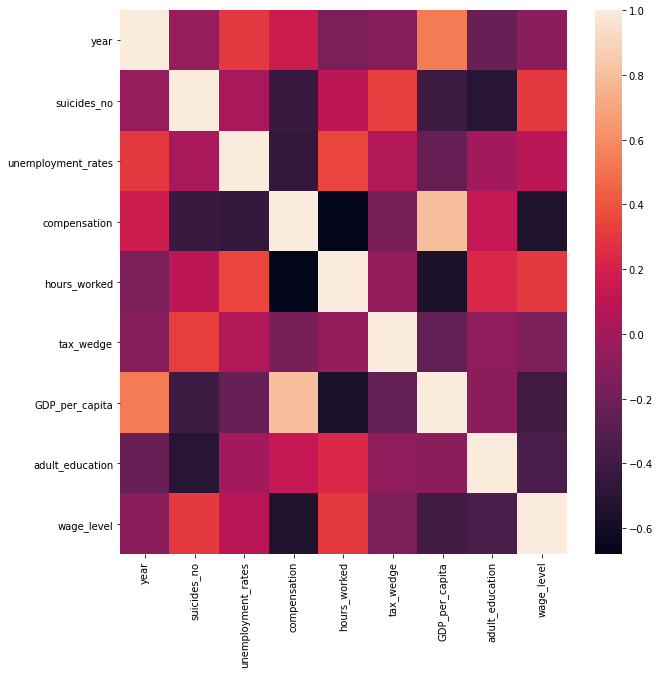

In [562]:
plt.figure(figsize=(10,10))
sns.heatmap(merged_data[merged_data['sex'] == 'male'].corr())

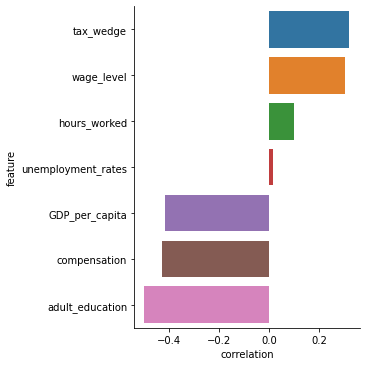

In [563]:
c = merged_data[merged_data['sex'] == 'male'].corr()['suicides_no'].reset_index()
c.columns = ['feature', 'correlation']
c = c[(c['feature'] != 'suicides_no') & (c['feature'] != 'year')].sort_values(by=['correlation'], ascending = False)

sns.catplot(y='feature', x='correlation', data=c,kind='bar', orient='h')

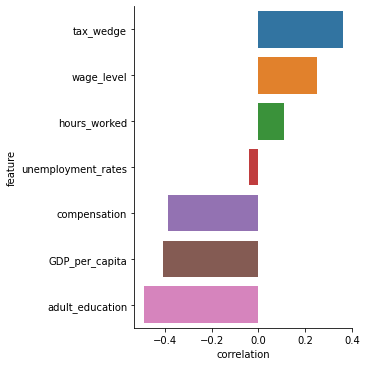

In [564]:
merged_data_no_outliers = suicide_no_outliers.merge(
    labour,
    on = ['country', 'sex', 'year'],
    how = 'left'
)

c_no_outliers = merged_data_no_outliers[merged_data_no_outliers['sex'] == 'male'].corr()['suicides_no'].reset_index()
c_no_outliers.columns = ['feature', 'correlation']
c_no_outliers = c_no_outliers[(c_no_outliers['feature'] != 'suicides_no') & (c_no_outliers['feature'] != 'year')].sort_values(by=['correlation'], ascending = False)

sns.catplot(y='feature', x='correlation', data=c_no_outliers,kind='bar', orient='h')

# Suicides rates / GDP per capita - Visualization

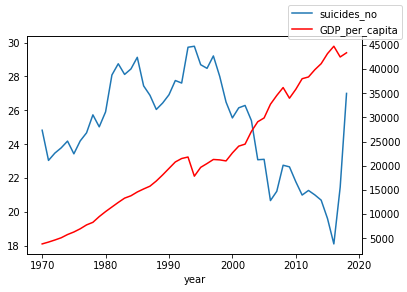

In [565]:
df = merged_data[merged_data['sex'] == 'male']
df = df[['year', 'suicides_no', 'GDP_per_capita']].groupby('year').mean().reset_index()
df = df[df['year'] >= 1970]

ax = df.plot(x='year', y='suicides_no', legend=False)
ax2 = ax.twinx()
df.plot(x="year", y="GDP_per_capita", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

<AxesSubplot:xlabel='GDP_per_capita', ylabel='suicides_no'>

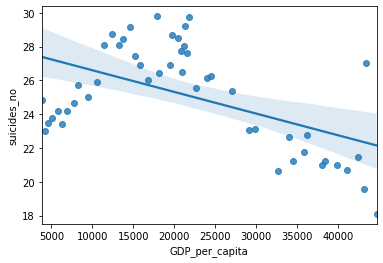

In [566]:
df = merged_data[merged_data['sex'] == 'male']
df = df[['year', 'sex', 'suicides_no', 'GDP_per_capita']].groupby(['year', 'sex']).mean().reset_index()
df = df[df['year'] >= 1970]

sns.regplot(
    x='GDP_per_capita',
    y='suicides_no',
    data=df
)

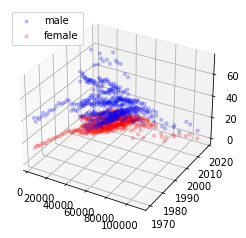

In [567]:
df_male = merged_data[['GDP_per_capita', 'year', 'suicides_no']][merged_data['sex'] == 'male']
df_female = merged_data[['GDP_per_capita', 'year', 'suicides_no']][merged_data['sex'] == 'female']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_male['GDP_per_capita'], df_male['year'], df_male['suicides_no'], label="male", alpha=0.2, c="blue", s=10)
ax.scatter(df_female['GDP_per_capita'], df_female['year'], df_female['suicides_no'], label="female", alpha=0.2, c="red", s=10)
plt.legend(loc=2)
plt.show()

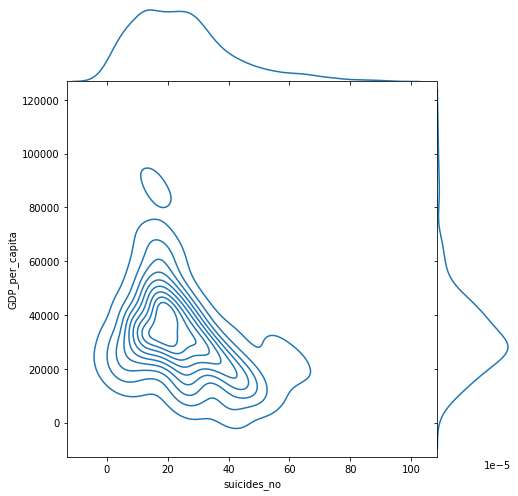

In [568]:
sns.jointplot(df_male.suicides_no,df_male.GDP_per_capita, kind="kde", height=7, space=0)
plt.show()

In [569]:
# Relating weakest overall economies with top suicide rates?

# CHAPTER 4 - MACHINE LEARNING

# Machine Learning Models

## Train and test splits


In [570]:
y = merged_data.suicides_no # Target variable
X = merged_data.drop('suicides_no', axis=1) # Input features

In [571]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

ModuleNotFoundError: No module named 'sklearn'

# CHAPTER 5 - RESULTS & CONCLUSIONS